In [25]:
import pandas as pd
import numpy as np
debates = pd.read_csv("/home/higoreller/projetos_pos/datasets/un-general-debates.csv")

In [ ]:
debates.head()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")

def tokenize(text):
    text = text.lower()
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(text)
    return ' '.join(new_words)

debates['debates_text_processed'] = debates.text.apply(tokenize)
debates['debates_text_processed'].head()

In [28]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stopwords.words('english'),
                        min_df=10,
                        max_features=5000)
tfidf.fit(debates['debates_text_processed'])
debates.loc[:, 'tfidf'] = debates['debates_text_processed'].apply(lambda t: tfidf.transform([t]).toarray()[0])

In [ ]:
debates.head()

In [29]:
corpus = np.array(debates.tfidf.tolist())

In [30]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

lda = LDA(n_components=5, random_state=42).fit(corpus)

In [ ]:
def get_model_topics(model, vectorizer, n_top_words=10):
    word_dict = {}
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topic_idx] = top_features

    return pd.DataFrame(word_dict)

get_model_topics(lda, tfidf)

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
corpus_matrix = np.matrix(corpus)

pyLDAvis.sklearn.prepare(lda, corpus_matrix, tfidf)

/home/higoreller/projetos_pos/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/higoreller/projetos_pos/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:513: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/home/higoreller/projetos_pos/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/higoreller/projetos_pos/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:513: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/home/higoreller/projetos_pos/venv/lib

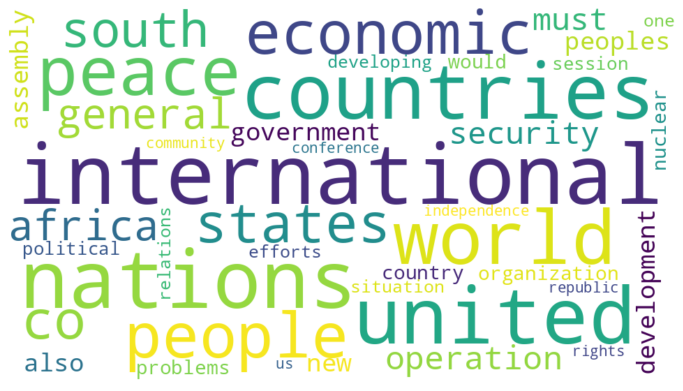

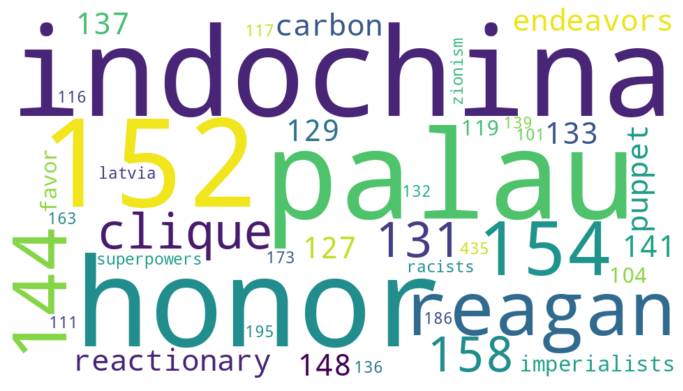

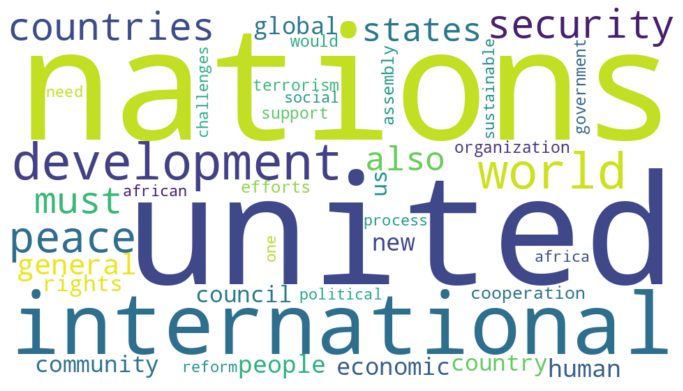

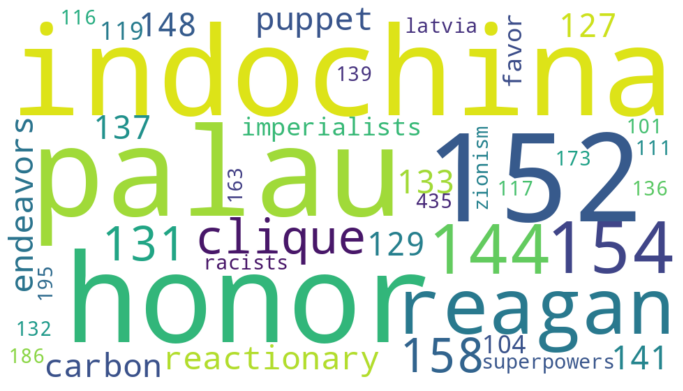

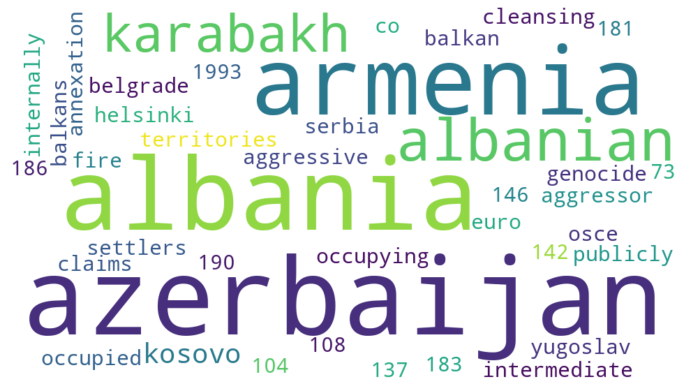

In [34]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1]  # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
                       width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12, 12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        # plt.savefig(f'topic{topic}.png')


# wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names())
wordcloud_topics(lda, tfidf.get_feature_names_out())